In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

In [2]:
class Linear_Regression:
    '.'
    def __init__(self):
        self.epoch = []
        self.train_loss = []        
        
    def fit(self, X, y, lr=0.001, epochs=10000, batch_size=2): 
        theta_initial = np.zeros((X.shape[1],1))
        theta_final =  np.zeros((X.shape[1],1))
        min_loss = 1e10
        for epoch in range(epochs):
            batch_loss = 0
            for batch in range(len(X)//batch_size):                
                batch_x = X[batch*batch_size : (batch+1)*batch_size, :]
                batch_y = y[batch*batch_size : (batch+1)*batch_size]                
                pred_y = self.predict(batch_x, theta_initial)
                batch_loss += self.mse(pred_y, batch_y, batch_size) * batch_size
                theta_final = theta_initial - (lr) * self.delta(batch_x, batch_y, theta_initial, batch_size) #*(1/batch_size)
                theta_initial = theta_final      
            batch_loss /= (len(X))
            if(batch_loss < min_loss):
                min_loss = batch_loss
                min_theta = theta_final
            self.train_loss.append(batch_loss)            
        return min_theta
                             
    def mse(self, pred_y, Y, m):
        return (1/m) * np.sum(np.square(pred_y - Y))
    
    def delta(self, train, Y, p, m):
        y_hat = np.dot(train, p)
        return  (1/m) * np.dot(train.T,(y_hat - Y))

    def predict(self, X, theta):
        pred_y = np.matmul(X , theta)
        return pred_y
    
    def evaluate(self, x, y, weights):
        pred_y = np.matmul(x, weights)
        return np.sum(np.square(pred_y - y)) * (1/len(x))
        
    def plot_curve(self):
        # self.epoch and self.trai_loss may be helpful here. 
        plt.clf()        
        plt.plot(self.train_loss)
        plt.title("Linear Regression - Loss vs Iterations")
        plt.xlabel("Iterations")
        plt.ylabel("Loss")
        plt.savefig("./loss.png")
        plt.show()
    

# Load data & data pre-processing

In [3]:
df_train = pd.DataFrame(pd.read_csv("./dataset/regression_train.csv"))
df_val   = pd.DataFrame(pd.read_csv("./dataset/regression_val.csv"))
df_test  = pd.DataFrame(pd.read_csv("./dataset/regression_test.csv"))
df_train.info()
df_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 938 entries, 0 to 937
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       938 non-null    int64  
 1   sex       938 non-null    object 
 2   bmi       938 non-null    float64
 3   children  938 non-null    int64  
 4   smoker    938 non-null    object 
 5   region    938 non-null    object 
 6   charges   938 non-null    float64
dtypes: float64(2), int64(2), object(3)
memory usage: 51.4+ KB


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
# TODO: You may do the labelEncoder here
# You may try different label encoding for training your own model
#### For multiple features, please use the following settings.####
# sex.female -> 0
# sex.male -> 1
# smoker.no -> 0
# smoker.yes -> 1
# region.northeast -> 0
# region.northwest -> 1
# region.southeast -> 2
# region.southwest -> 3
##################################################################

def data_preparation(train, val, test):
    train = np.array(train) #938x1
    test = np.array(test)
    val = np.array(val)          
    trainX = np.array(list(map(lambda x: np.append([1],x) , train))) #938x2
    testX = np.array(list(map(lambda x: np.append([1],x) , test)))
    valX = np.array(list(map(lambda x: np.append([1],x) , val)))      
    return trainX, valX, testX

def Label_Encoding(df_raw):
    df = df_raw.copy()
    df['sex'].replace(to_replace=['male','female'], value=[1,0], inplace=True)
    df['smoker'].replace(to_replace=['yes','no'], value=[1,0], inplace=True)
    df['region'].replace(to_replace=['northeast','northwest','southeast','southwest'], value=[0,1,2,3], inplace=True)
    return df

def Dummy_Encoding(df):
    sex_dummy = pd.get_dummies(df['sex'])
    smoker_dummy = pd.get_dummies(df['smoker'])
    region_dummy = pd.get_dummies(df['region'])
    df = pd.concat([df,sex_dummy,smoker_dummy,region_dummy], axis=1)
    df.rename(columns={'no': 'smoker_no', 'yes': 'smoker_yes'}, inplace=True)
    df = df.drop(['sex','smoker','region'], axis=1)
    return df
    
def Feature_Generating(df):
    df['age*smoker_yes'] = df.age * df.smoker_yes
    df['bmi*smoker_yes'] = df.bmi * df.smoker_yes
    df['bmi_bins_smoker_yes'] = pd.cut(x=df['bmi']*df.smoker_yes, bins=df['bmi'].quantile([0, .25, .5, .75, 1.]))
    df = pd.get_dummies(df)
    return df


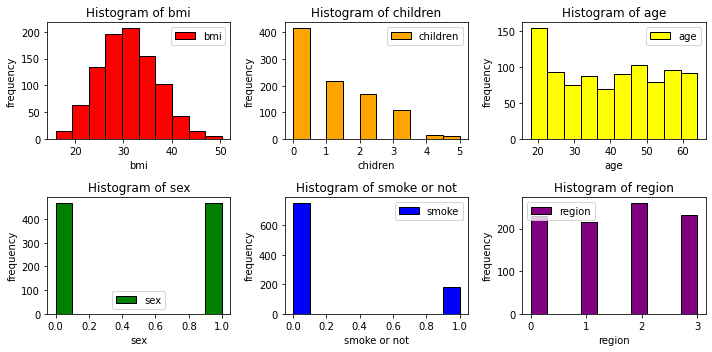

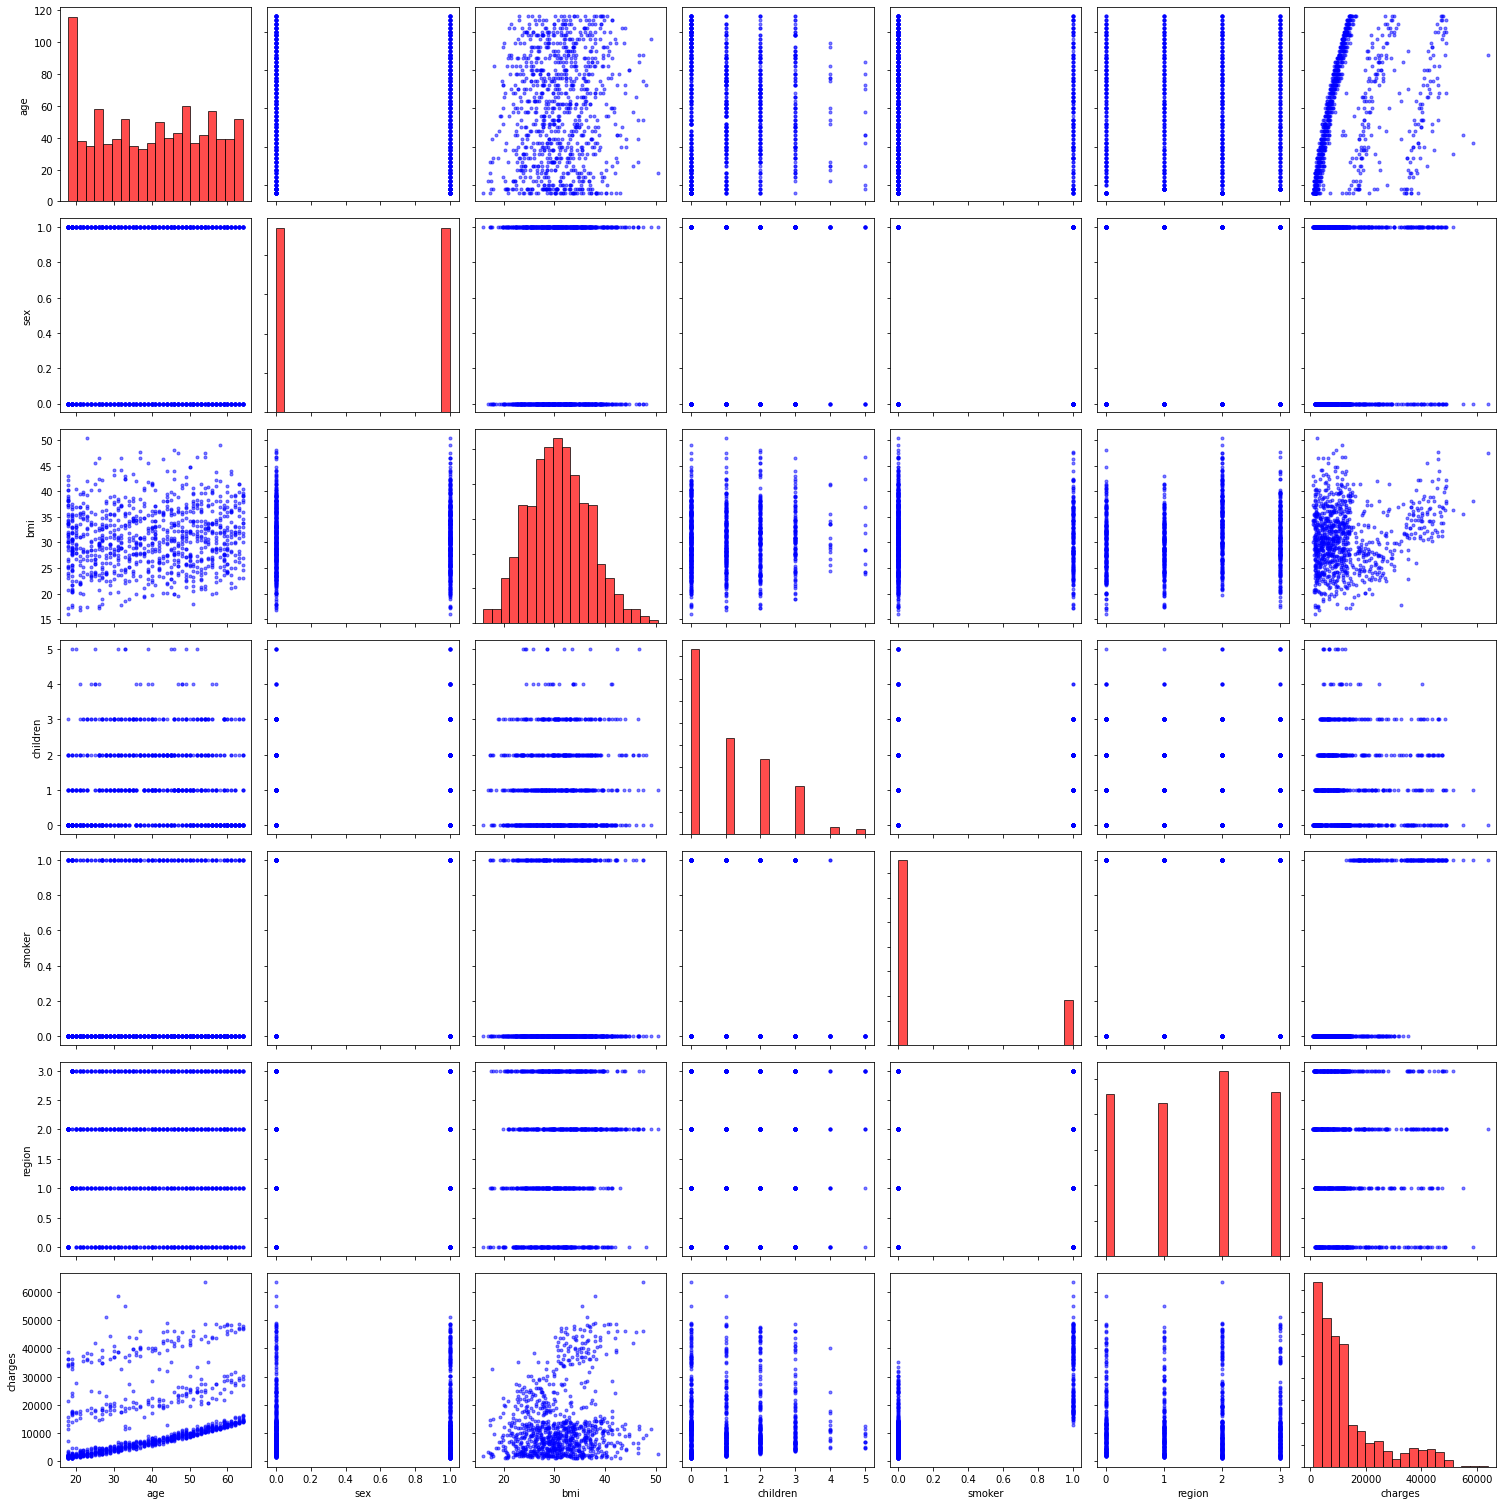

               age       sex       bmi  children    smoker    region   charges
age       1.000000 -0.053253  0.105642  0.033802 -0.004509 -0.006884  0.324213
sex      -0.053253  1.000000  0.015213  0.023992  0.068751 -0.002937  0.025908
bmi       0.105642  0.015213  1.000000  0.025009 -0.005701  0.141745  0.189973
children  0.033802  0.023992  0.025009  1.000000 -0.012050  0.000552  0.048509
smoker   -0.004509  0.068751 -0.005701 -0.012050  1.000000 -0.012810  0.789616
region   -0.006884 -0.002937  0.141745  0.000552 -0.012810  1.000000 -0.026971
charges   0.324213  0.025908  0.189973  0.048509  0.789616 -0.026971  1.000000


In [5]:
def Pair_Plot(data):
    fig, ax = plt.subplots(7, 7, figsize=(21, 21))
    for i, col_i in enumerate(data.columns):
        for j, col_j in enumerate(data.columns):
            if i == j:
                ax[i, j].hist(data[col_i], bins=20, color='red', edgecolor='black', alpha=0.7)
            else:
                ax[i, j].scatter(data[col_j], data[col_i], marker='.', color='blue', alpha=0.5)
            if i == 6:
                ax[i, j].set_xlabel(col_j)
            else:
                ax[i, j].set_xticklabels([])
            if j == 0:
                ax[i, j].set_ylabel(col_i)
            else:
                ax[i, j].set_yticklabels([])
    plt.tight_layout()
    plt.show()
    
def Histogram_Plot(data):
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10,5))
    plt.subplot(2, 3, 1)
    plt.hist(data.bmi, edgecolor="black", color="red", label="bmi")
    plt.title('Histogram of bmi')
    plt.xlabel('bmi') 
    plt.ylabel('frequency') 
    plt.legend()
    plt.subplot(2, 3, 2)
    plt.hist(data.children, edgecolor='black', color="orange", label="children")
    plt.title('Histogram of children')
    plt.xlabel('chidren')
    plt.ylabel('frequency')
    plt.legend()
    plt.subplot(2, 3, 3)
    plt.hist(data.age, edgecolor='black', color="yellow", label="age")
    plt.title('Histogram of age')
    plt.xlabel('age')
    plt.ylabel('frequency')
    plt.legend()
    plt.subplot(2, 3, 4)
    plt.hist(data.sex, edgecolor='black', color="green", label="sex")
    plt.title('Histogram of sex')
    plt.xlabel('sex')
    plt.ylabel('frequency')
    plt.legend()
    plt.subplot(2, 3, 5)
    plt.hist(data.smoker, edgecolor='black', color="blue", label="smoke")
    plt.title('Histogram of smoke or not')
    plt.xlabel('smoke or not')
    plt.ylabel('frequency')
    plt.legend()
    plt.subplot(2, 3, 6)
    plt.hist(data.region, edgecolor='black', color="purple", label="region")
    plt.title('Histogram of region')
    plt.xlabel('region')
    plt.ylabel('frequency')
    plt.legend()
    plt.tight_layout()
    plt.show()

Histogram_Plot(Label_Encoding(df_train))
Pair_Plot(Label_Encoding(df_train))
print(Label_Encoding(df_train).corr())

# Single feature (using bmi)

In [6]:
# Do not modify here

x_train = df_train.drop(['charges'], axis=1)
y_train = df_train['charges']
x_train = x_train[['bmi']]

x_val = df_val.drop(['charges'], axis=1)
y_val = df_val['charges']
x_val = x_val[['bmi']]

x_test = df_test.drop(['charges'], axis=1)
x_test = x_test[['bmi']]


# TODO: You may convert data to NumPy here 

x_train_raw = np.array(x_train)
x_val_raw = np.array(x_val)
x_train, x_val, x_test = data_preparation(x_train, x_val, x_test)
y_train = np.array(y_train).reshape(-1,1)
y_val = np.array(y_val).reshape(-1,1)


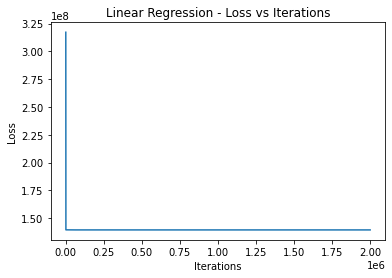

Intercepts:  [1382.536816]
Weights:  [380.13465625]
training loss:  139562065.48342776
validation loss:  136920284.33792174


In [7]:
# TODO: Tune the parameters. Refer to slide page 9

lr = 5e-4
epochs = 2000000
batch_size = x_train.shape[0]
linear_reg = Linear_Regression()
theta = linear_reg.fit(x_train, y_train, lr=lr, epochs=epochs, batch_size=batch_size)
linear_reg.plot_curve()

print("Intercepts: ", theta[0])
print("Weights: ", theta[1])
print('training loss: ', linear_reg.evaluate(x_train, y_train, theta))
print('validation loss: ', linear_reg.evaluate(x_val, y_val, theta))

test_pred = linear_reg.predict(x_test, theta)

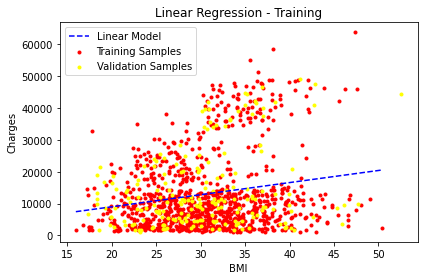

In [8]:
# TODO: Use matplotlib to plot the predicted line with the training and validation samples

w0 = theta[0]
w1 = theta[1]
y1 = w1 * min(x_train_raw) + w0
y2 = w1 * max(x_train_raw) + w0

plt.clf()
plt.scatter(x_train_raw, y_train, marker='.', color='red', label='Training Samples')
plt.scatter(x_val_raw, y_val, marker='.', color='yellow', label='Validation Samples')
plt.plot([min(x_train_raw), max(x_train_raw)], [y1, y2], color='blue', 
        markerfacecolor='blue', markersize=10, linestyle='dashed', label="Linear Model")

plt.title("Linear Regression - Training")
plt.xlabel("BMI")
plt.ylabel("Charges")
plt.legend()
plt.tight_layout()
plt.show()

# Multiple features

In [9]:
# Do not modify here

x_train = df_train.drop(['charges'], axis=1)
y_train = df_train['charges']

x_val = df_val.drop(['charges'], axis=1)
y_val = df_val['charges']

x_test = df_test.drop(['charges'], axis=1)


# TODO: You may convert data to NumPy here 

x_train = Label_Encoding(x_train)
x_val = Label_Encoding(x_val)
x_test = Label_Encoding(x_test)
x_train, x_val, x_test = data_preparation(x_train, x_val, x_test)
y_train = np.array(y_train).reshape(-1,1)
y_val = np.array(y_val).reshape(-1,1)

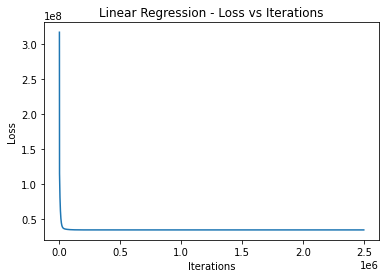

Intercepts:  [-11857.05721739]
Weights: 
 [[  259.85086355]
 [ -383.54525304]
 [  333.33251186]
 [  442.55747612]
 [24032.22098955]
 [ -416.01438888]]
training loss:  34697170.25351918
validation loss:  41958565.746851996


In [10]:
# TODO: Tune the parameters. Refer to slide page 10

lr = 5e-4
epochs = 2500000
batch_size = x_train.shape[0]
linear_reg = Linear_Regression()
theta = linear_reg.fit(x_train, y_train, lr=lr, epochs=epochs, batch_size=batch_size)
linear_reg.plot_curve()

print("Intercepts: ", theta[0])
print("Weights: \n", theta[1:])
print('training loss: ', linear_reg.evaluate(x_train, y_train, theta))
print('validation loss: ', linear_reg.evaluate(x_val, y_val, theta))

test_pred = linear_reg.predict(x_test, theta)

# Train your own model and predict for testing data.

                 age       bmi  children   charges    female      male  \
age         1.000000  0.105642  0.033802  0.324213  0.053253 -0.053253   
bmi         0.105642  1.000000  0.025009  0.189973 -0.015213  0.015213   
children    0.033802  0.025009  1.000000  0.048509 -0.023992  0.023992   
charges     0.324213  0.189973  0.048509  1.000000 -0.025908  0.025908   
female      0.053253 -0.015213 -0.023992 -0.025908  1.000000 -1.000000   
male       -0.053253  0.015213  0.023992  0.025908 -1.000000  1.000000   
smoker_no   0.004509  0.005701  0.012050 -0.789616  0.068751 -0.068751   
smoker_yes -0.004509 -0.005701 -0.012050  0.789616 -0.068751  0.068751   
northeast   0.018921 -0.118775  0.013761  0.031987 -0.001270  0.001270   
northwest   0.002003 -0.139207 -0.009561 -0.045389 -0.019092  0.019092   
southeast  -0.041123  0.252034 -0.022976  0.060100  0.032250 -0.032250   
southwest   0.021920 -0.007685  0.019493 -0.049981 -0.013603  0.013603   

            smoker_no  smoker_yes  no

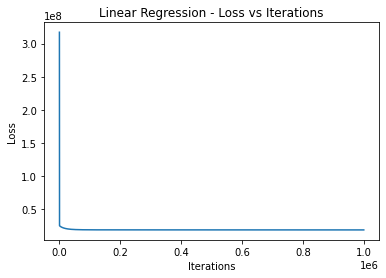

Intercepts:  [-1012.39485894]
Weights: 
 [[  272.26271052]
 [    9.31456587]
 [  470.65732078]
 [ -179.09168802]
 [ -833.30317092]
 [-1406.71430736]
 [  394.31944841]
 [  513.7576147 ]
 [ -125.43387086]
 [ -495.84715871]
 [ -904.87144406]
 [  -17.6977124 ]
 [  737.96639928]
 [-5863.18156945]
 [-5594.77750255]
 [ 6047.24060682]
 [ 5805.0379136 ]]
training loss:  18967807.18141867
validation loss:  23527678.2112429
-------------------------------------------


In [11]:
my_df_train = Dummy_Encoding(df_train)
my_df_val = Dummy_Encoding(df_val)
my_df_test = Dummy_Encoding(df_test)
print(my_df_train.corr())
my_df_train = Feature_Generating(my_df_train)
my_df_val = Feature_Generating(my_df_val)
my_df_test = Feature_Generating(my_df_test)
print("----------------------------------------------")

x_train = my_df_train.drop(['charges'], axis=1)
y_train = my_df_train['charges']
x_val = my_df_val.drop(['charges'], axis=1)
y_val = my_df_val['charges']
x_test = my_df_test.drop(['charges'], axis=1)

x_train, x_val, x_test = data_preparation(x_train, x_val, x_test)
y_train = np.array(y_train).reshape(-1,1)
y_val = np.array(y_val).reshape(-1,1)

lr = 5e-4
epochs = 1000000
batch_size = x_train.shape[0]
linear_reg = Linear_Regression()
theta = linear_reg.fit(x_train, y_train, lr=lr, epochs=epochs, batch_size=batch_size)
linear_reg.plot_curve()
print("Intercepts: ", theta[0])
print("Weights: \n", theta[1:])
print('training loss: ', linear_reg.evaluate(x_train, y_train, theta))
print('validation loss: ', linear_reg.evaluate(x_val, y_val, theta))
print("-------------------------------------------")

# from sklearn.linear_model import LinearRegression
# lm = LinearRegression(fit_intercept=True)
# lm.fit(x_train,y_train)
# print(lm.intercept_)
# coeff_df = pd.DataFrame(lm.coef_,x_train.columns,columns=['Coefficient'])
# print(coeff_df)
# score = lm.score(x_val, y_val)
# print('Score: ', score)
# print('Accuracy: ' + str(score*100) + '%')

In [12]:
test_pred = linear_reg.predict(x_test, theta)
print("test_pred shape: ", test_pred.shape)
assert test_pred.shape == (200, 1)

test_pred shape:  (200, 1)


# Output the csv file

In [13]:
df_test = pd.DataFrame(pd.read_csv("./regression_test.csv"))
df_test["charges"] = test_pred
df_test.to_csv("output.csv")